# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score,
                             confusion_matrix,
                             roc_curve, auc, roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда градиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функции f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    grad = 2*np.sin(w)*np.cos(w)
    
    return grad

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнoго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
        
    #  YOUR CODE. Не забудьте про lr!
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

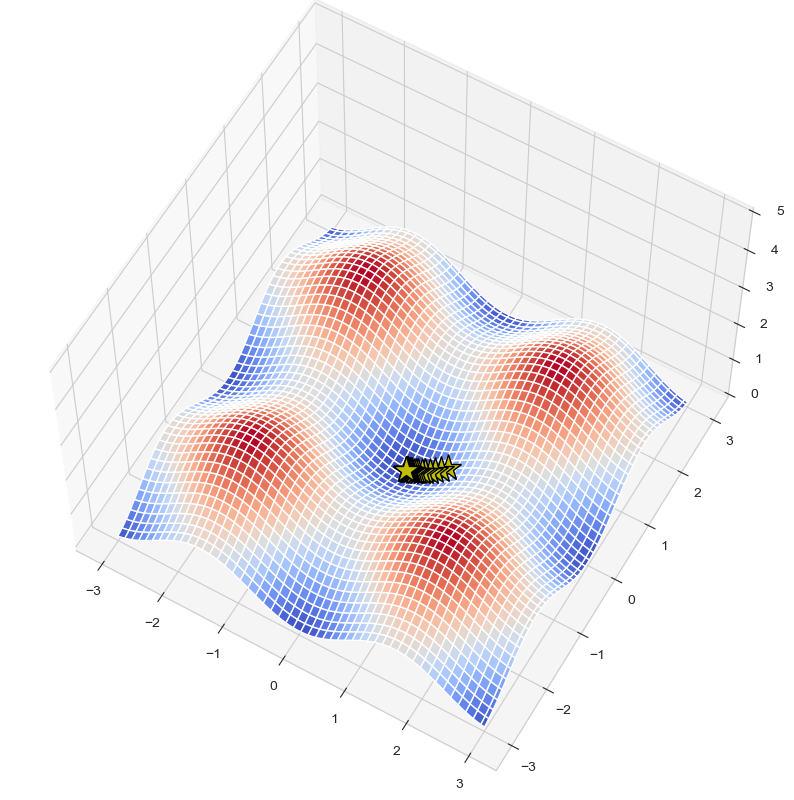

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

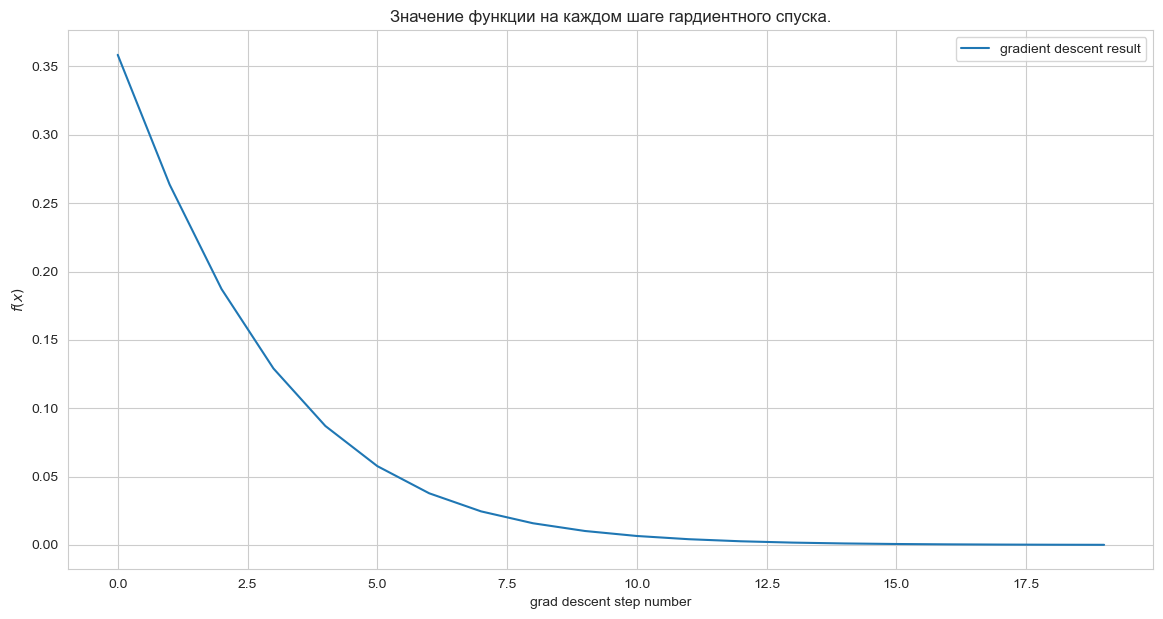

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регрессии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    mse = np.mean((y_true - y_pred)**2)
    
    return mse


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    grad = 2 / y_true.shape[0] * np.dot(X.T, y_pred - y_true)

    return grad

class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
            print(f'random{self.W}')
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = np.dot(X_test, self.W)
        print(f'not random{self.W}')
        return y_pred
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

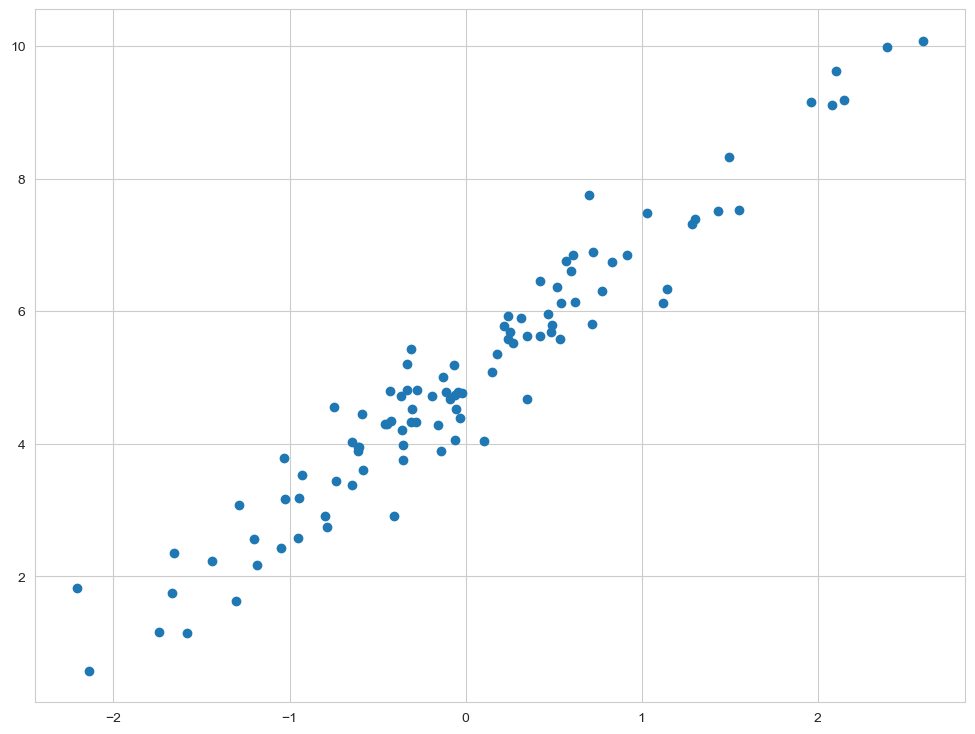

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()
custom_lin_reg.fit(X, y)

random[[-1.88290132]
 [ 1.24657858]]
not random[[-1.88290132]
 [ 1.24657858]]
not random[[-1.74529938]
 [ 1.25933756]]
not random[[-1.61044855]
 [ 1.27186924]]
not random[[-1.47829382]
 [ 1.28417766]]
not random[[-1.34878128]
 [ 1.29626676]]
not random[[-1.22185812]
 [ 1.30814043]]
not random[[-1.09747256]
 [ 1.3198025 ]]
not random[[-0.97557386]
 [ 1.33125671]]
not random[[-0.8561123 ]
 [ 1.34250675]]
not random[[-0.73903915]
 [ 1.35355624]]
not random[[-0.62430666]
 [ 1.36440873]]
not random[[-0.51186803]
 [ 1.37506772]]
not random[[-0.40167739]
 [ 1.38553665]]
not random[[-0.29368981]
 [ 1.39581887]]
not random[[-0.18786122]
 [ 1.40591771]]
not random[[-0.08414848]
 [ 1.41583642]]
not random[[0.01749073]
 [1.4255782 ]]
not random[[0.11709787]
 [1.43514617]]
not random[[0.21471357]
 [1.44454344]]
not random[[0.31037763]
 [1.45377303]]
not random[[0.40412908]
 [1.46283791]]
not random[[0.49600617]
 [1.47174102]]
not random[[0.58604636]
 [1.48048521]]
not random[[0.67428638]
 [1.489073

My custom linear regression

not random[[4.9997881 ]
 [1.95949099]]


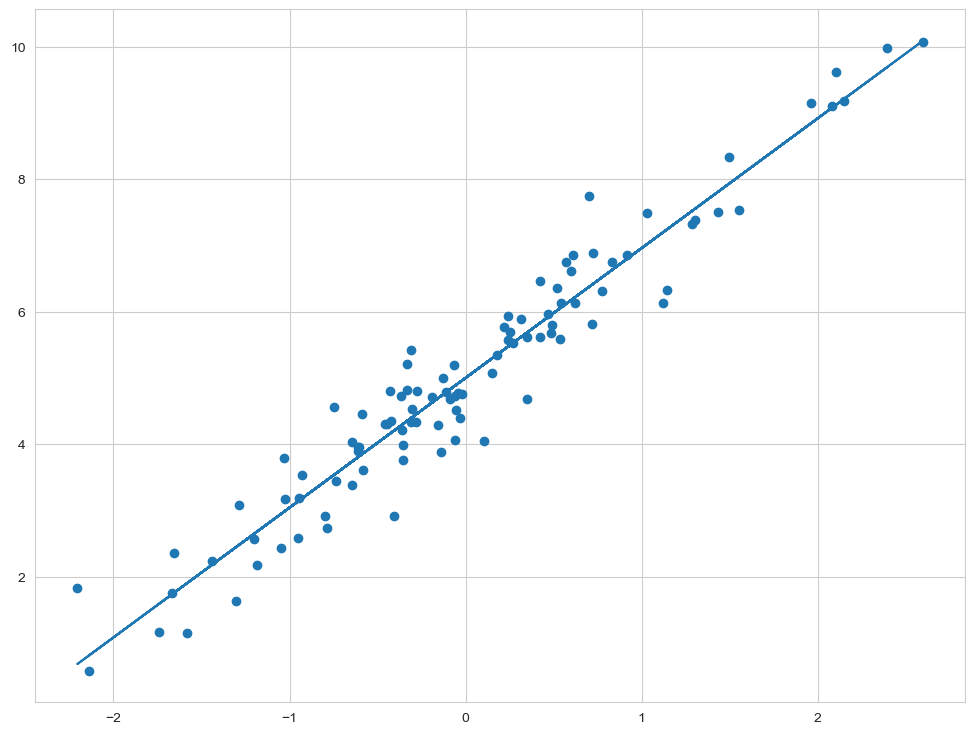

In [17]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

Хорошо предсказывает!

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [18]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

In [19]:
df = pd.DataFrame(X, columns=feature_names)
df["Target"] = y
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


#### EDA

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [21]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [22]:
for col in df.columns:
    print(f'NAs in {col}: {df[col].isna().sum()}')

NAs in MedInc: 0
NAs in HouseAge: 0
NAs in AveRooms: 0
NAs in AveBedrms: 0
NAs in Population: 0
NAs in AveOccup: 0
NAs in Latitude: 0
NAs in Longitude: 0
NAs in Target: 0


In [23]:
for col in df.columns:
    print(f'Unique values in {col}: {df[col].unique().shape[0]}')

Unique values in MedInc: 12928
Unique values in HouseAge: 52
Unique values in AveRooms: 19392
Unique values in AveBedrms: 14233
Unique values in Population: 3888
Unique values in AveOccup: 18841
Unique values in Latitude: 862
Unique values in Longitude: 844
Unique values in Target: 3842


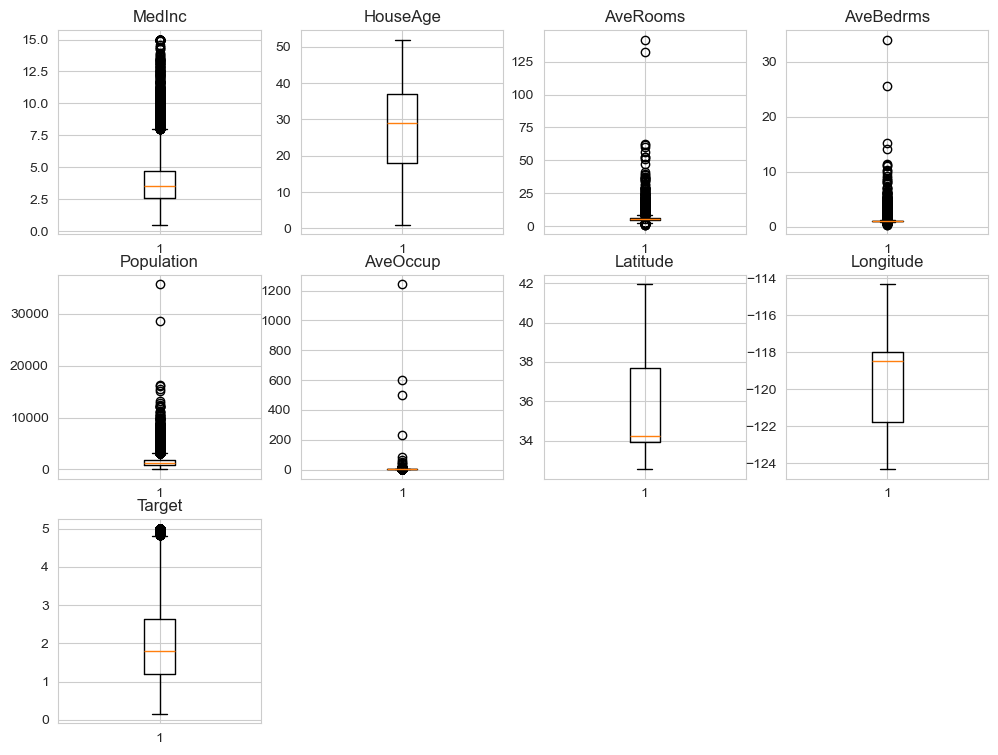

In [24]:
for i, col in enumerate(df.columns):
    plt.subplot(3, 4, i+1)
    plt.boxplot(df[col])
    plt.title(col)
plt.show()

Есть предложение убрать только самые-самые странные выбросы:
1) в AveRooms два значения, большие 75 комнат
2) в AveBedrooms два значения, большие 20 спален
3) в Population два самых экстремальных значения
4) в AveOccup четыре самых

In [25]:
df_filtered = df[(df['AveRooms'] < 75) & (df['AveBedrms'] < 20) &
                 (df['Population'] < 20000) & (df['AveOccup'] < 200)]

Посмотрим, как теперь выглядят данные:

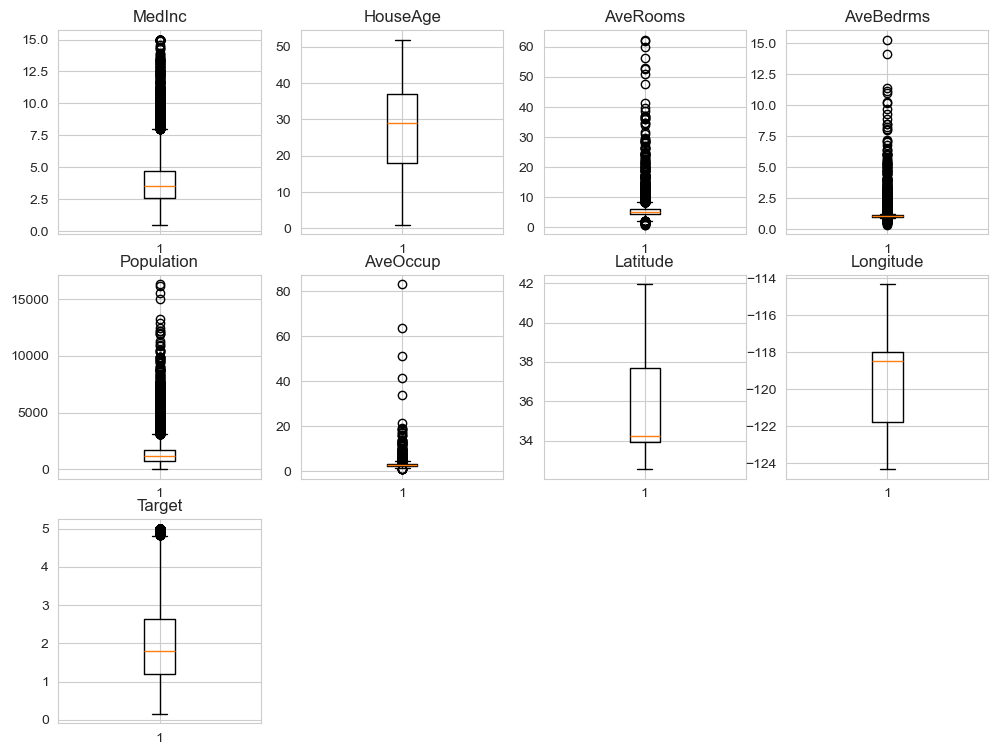

In [26]:
for i, col in enumerate(df_filtered.columns):
    plt.subplot(3, 4, i+1)
    plt.boxplot(df_filtered[col])
    plt.title(col)
plt.show()

Стало, на мой скромный взгляд, лучше. Посмотрим еще дополнительно на распределения:

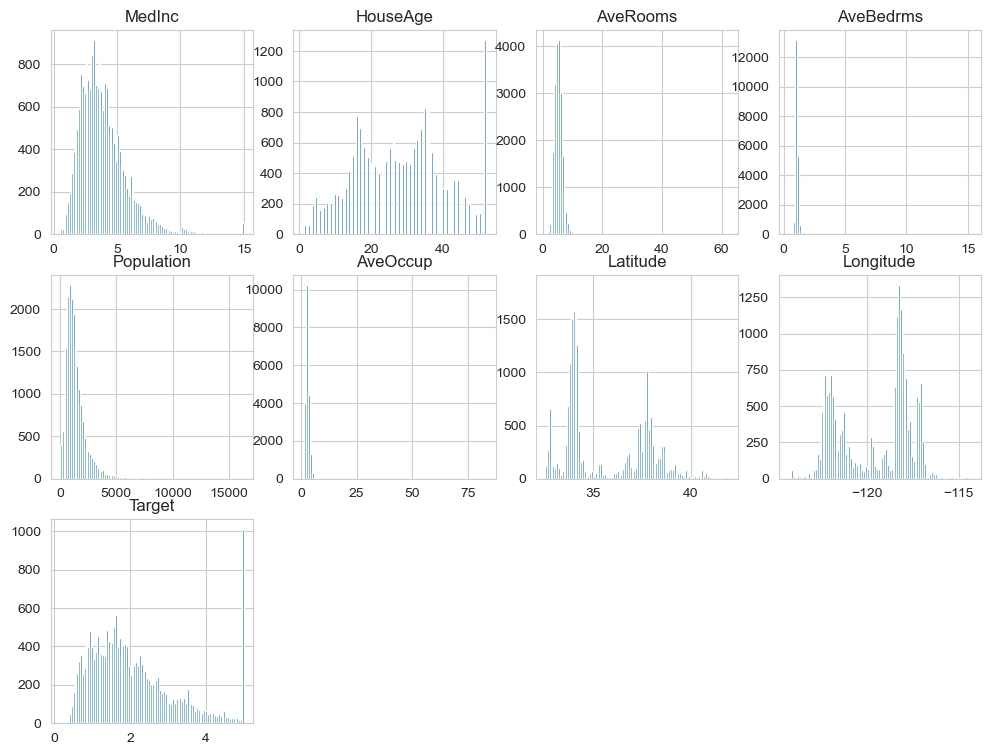

In [27]:
for i, col in enumerate(df_filtered.columns):
    plt.subplot(3, 4, i+1)
    plt.hist(df_filtered[col], bins=100)
    plt.title(col)
plt.show()

Теперь готовим данные к разделению и делим:

In [28]:
X_filtered = df_filtered.drop("Target", axis=1).to_numpy(dtype=object)
y_filtered = df_filtered["Target"].to_numpy(dtype=object)
X_filtered = df_filtered.drop("Target", axis=1)
y_filtered = df_filtered["Target"]

X_train, X_test, y_train, y_test = train_test_split(X_filtered, 
                                                    y_filtered, 
                                                    test_size=0.15,
                                                    random_state=SEED)

In [29]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), df_filtered.drop("Target", axis=1).columns)
])
lin_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regression", LinearRegression())
])

In [30]:
lin_reg_pipeline.fit(X_train, y_train)
y_test_pred = lin_reg_pipeline.predict(X_test)

Посчитаем статистики:

In [31]:
print(f'MSE = {mean_squared_error(y_test, y_test_pred)}')
print(f'R2 = {r2_score(y_test, y_test_pred)}')

MSE = 0.575209921137101
R2 = 0.5705978986898856


Теперь смотрим на коэффициенты:

In [32]:
lin_reg_pipeline.named_steps['regression'].coef_

array([ 0.82676606,  0.12936771, -0.23039262,  0.26234812,  0.02394228,
       -0.17741886, -0.9046331 , -0.8599681 ])

Мы получили модель с неплохим R2 = 0.57, но достаточно высоким MSE = 0.57. Наиболее важными признаками является доход (первый коэффициент) и координаты положения дома (последние два).

### Задание 3. Реализация логистической регресcии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [33]:
def sigmoid(x):
    # output результат X@w (-inf, +inf)
    return 1 / (1 + np.exp(-x))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [34]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    bce_loss = -(1/n) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return bce_loss
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    bce_grad = np.dot(X.T, sigmoid(y_pred)-y_true)
    
    return bce_grad


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [35]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
        
        linear_output = np.dot(X_test, self.W)  
        probabilities = sigmoid(linear_output)
        X_test_prediction = np.where(probabilities >= 0.5, 1, 0)

        return X_test_prediction
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [36]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

In [37]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

random[[-0.14679823]
 [ 0.68973497]]


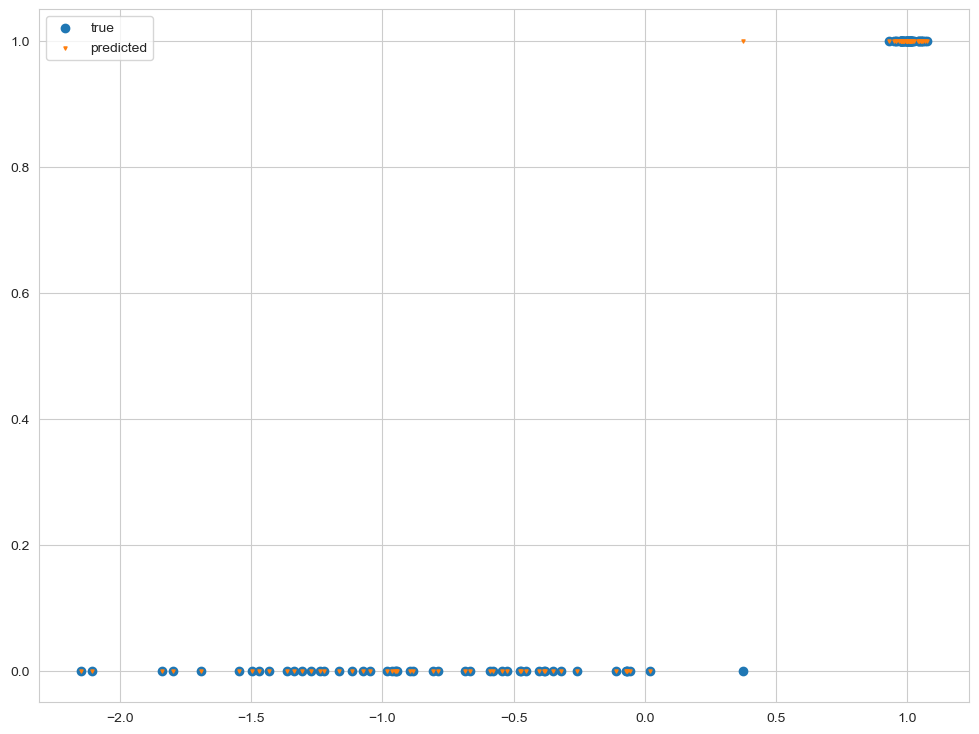

In [38]:
plt.scatter(X, y, label='true')
plt.scatter(X, y_pred, label='predicted', marker='v', s=5)
plt.legend();

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [39]:
print(f'accuracy = {accuracy_score(y_pred, y)}')
print(f'precision = {precision_score(y_pred, y)}')
print(f'recall = {recall_score(y_pred, y)}')
print(f'f1 = {f1_score(y_pred, y)}')

accuracy = 0.99
precision = 1.0
recall = 0.9803921568627451
f1 = 0.9900990099009901


Все хорошенькие! Ну это и по графику видно, что модель норм

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам [покемонов](https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [40]:
pokemon = pd.read_csv("../data_folder/raw_data/Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [41]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [42]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [43]:
for col in pokemon.columns:
    print(f'NAs in {col}: {pokemon[col].isna().sum()}')

NAs in #: 0
NAs in Name: 0
NAs in Type 1: 0
NAs in Type 2: 386
NAs in Total: 0
NAs in HP: 0
NAs in Attack: 0
NAs in Defense: 0
NAs in Sp. Atk: 0
NAs in Sp. Def: 0
NAs in Speed: 0
NAs in Generation: 0
NAs in Legendary: 0


Выбросим Type 2 - сликшом много нанов.

In [44]:
pokemon = pokemon.drop(['Type 2'], axis=1)
pokemon

,#,Name,Type 1,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,680,80,160,60,170,130,80,6,True


In [45]:
num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
cat_cols = ['Type 1', 'Generation']

In [46]:
for col in pokemon.columns:
    print(f'Unique values in {col}: {pokemon[col].unique().shape[0]}')

Unique values in #: 721
Unique values in Name: 800
Unique values in Type 1: 18
Unique values in Total: 200
Unique values in HP: 94
Unique values in Attack: 111
Unique values in Defense: 103
Unique values in Sp. Atk: 105
Unique values in Sp. Def: 92
Unique values in Speed: 108
Unique values in Generation: 6
Unique values in Legendary: 2


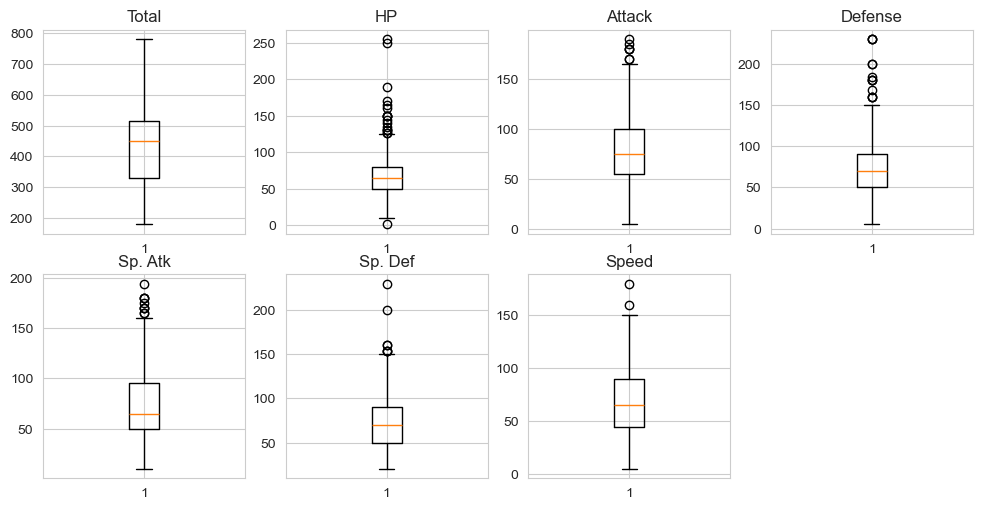

In [47]:
for i, col in enumerate(num_cols):
    plt.subplot(3, 4, i + 1)
    plt.boxplot(pokemon[col])
    plt.title(col)
plt.show()

Для категориальных колонок: для Legendary перекодируем 0 - False, 1 - True и не будем выкидывать остальные
Для колонок с численными данными: для HP, Defense, Sp. Def выкинем то, что больше 200 (выглядят как совсем далекие выбросы)

In [48]:
pokemon['Legendary'] = pokemon['Legendary'].astype(int)
pokemon_filtered = pokemon[(pokemon['HP'] < 200) & (pokemon['Defense'] < 200) &
                 (pokemon['Sp. Def'] < 200)]

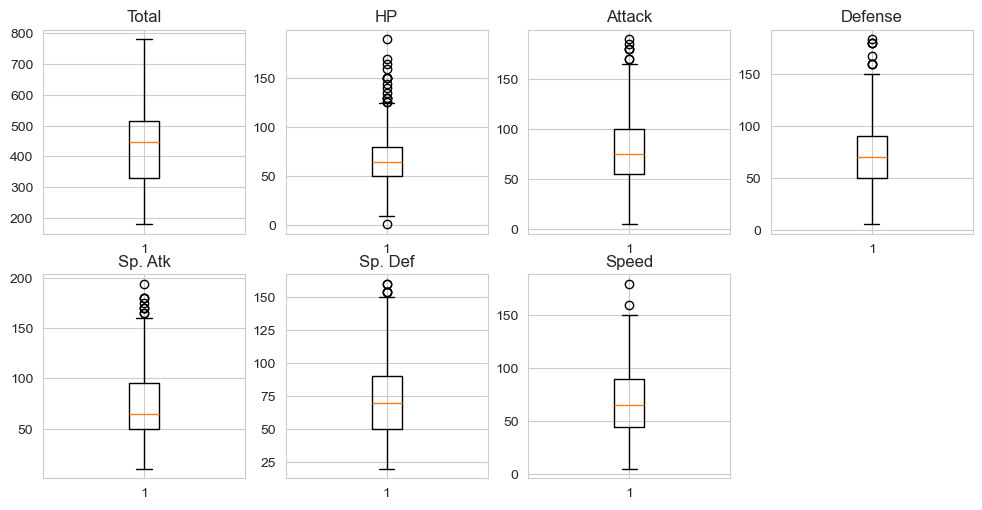

In [49]:
for i, col in enumerate(num_cols):
    plt.subplot(3, 4, i + 1)
    plt.boxplot(pokemon_filtered[col])
    plt.title(col)
plt.show()

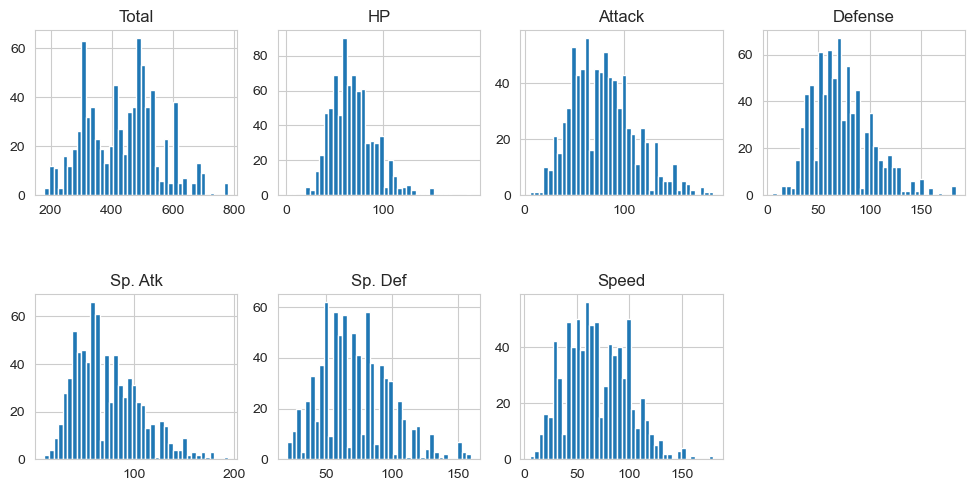

In [50]:
for i, col in enumerate(num_cols):
    plt.subplot(3, 4, i+1)
    plt.hist(pokemon_filtered[col], bins=40)
    plt.title(col)
    
plt.subplots_adjust(wspace=0.2, hspace=0.6)   
plt.show()

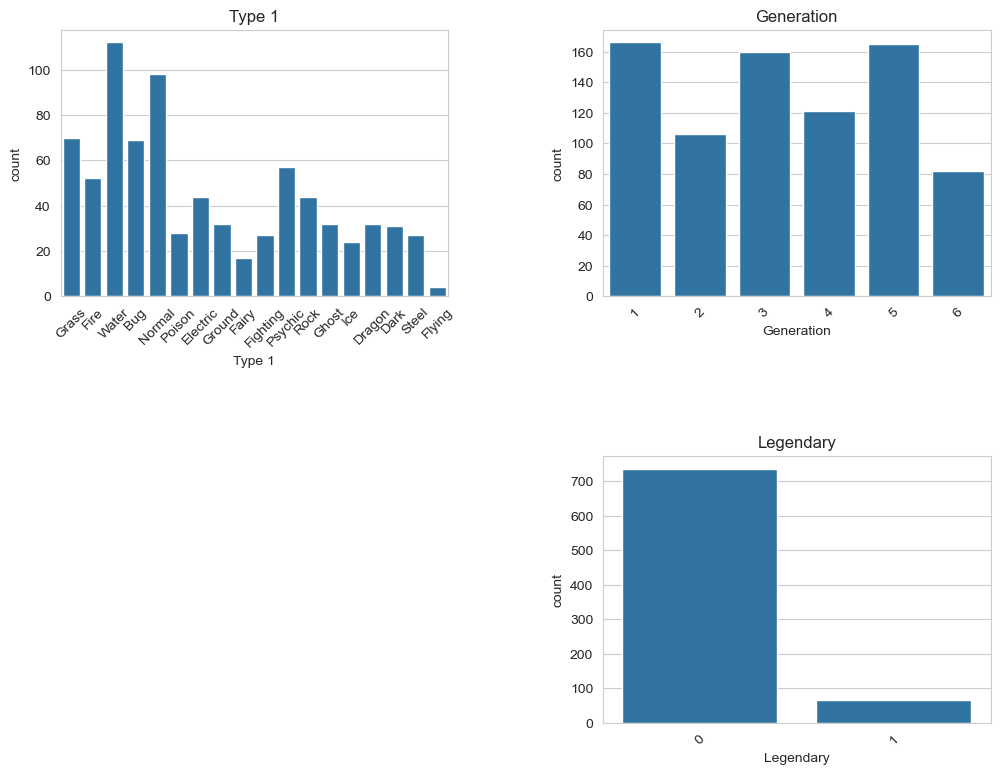

In [51]:
for i, col in enumerate(cat_cols):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=pokemon, x=col)
    plt.xticks(rotation=45)
    plt.title(col)
    
plt.subplot(2, 2, 4)   
sns.countplot(data=pokemon, x='Legendary')
plt.xticks(rotation=45)
plt.title('Legendary')
    
plt.subplots_adjust(wspace=0.4, hspace=0.6)    
plt.show()

Виден очень большой дисбаланс классов, особенно для колонки legendary, но попробуем поработать дальше. Дальше посмотрим на зависимости признаков между собой.

In [52]:
corr_matrix = pokemon.drop(['Type 1', 'Generation', '#', 'Name', 'Legendary'], axis=1).corr()

<Figure size 600x400 with 0 Axes>

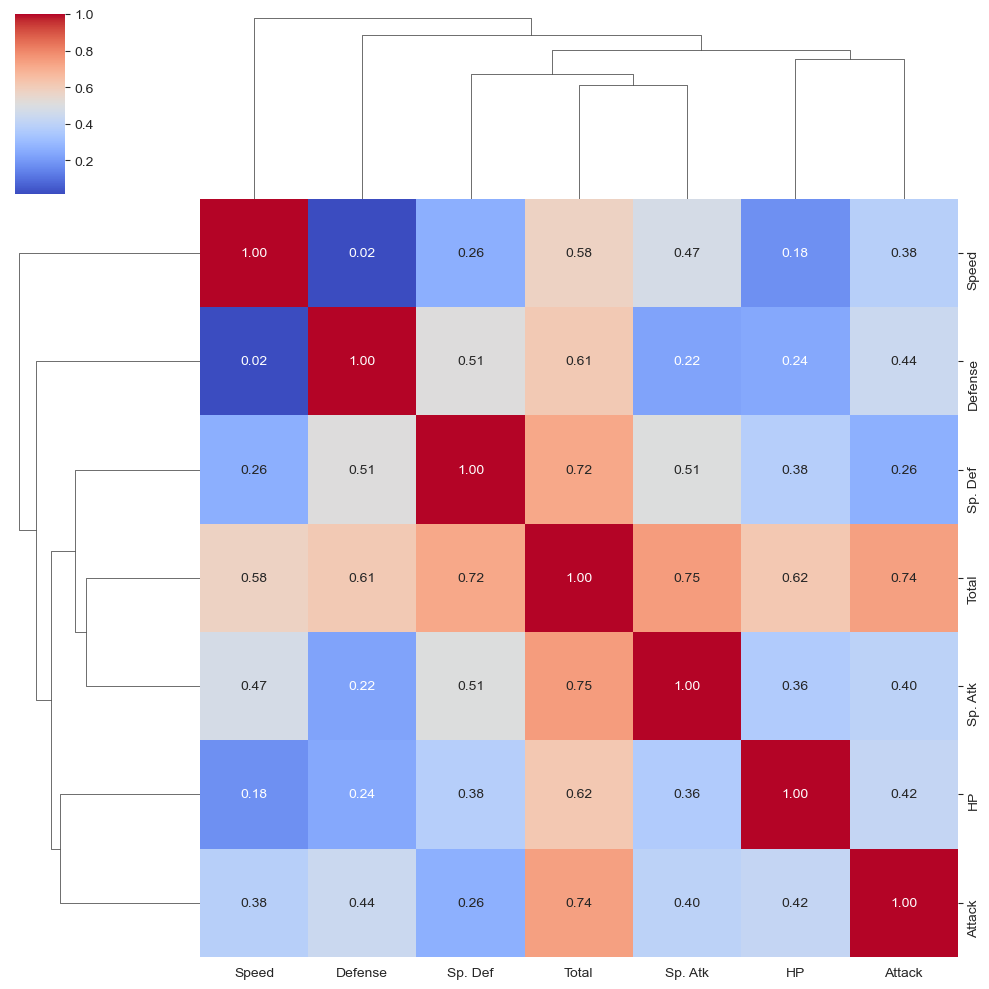

In [53]:
plt.figure(figsize=(6, 4))
sns.clustermap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Как видно по корреляции, больше всего зависит Total от других признаков, также  Sp.Def коррелирует с Defense и Sp. Atk 

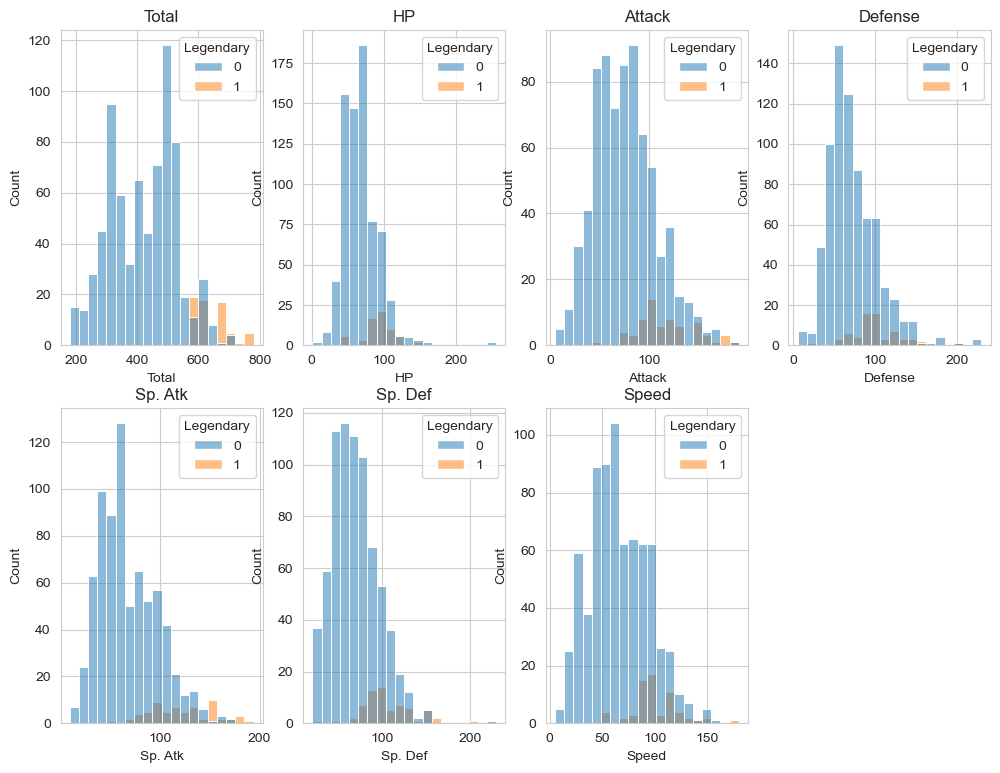

In [54]:
for i, col in enumerate(num_cols):
    plt.subplot(2, 4, i+1)
    sns.histplot(data=pokemon, x=col, hue='Legendary', bins=20)
    plt.title(col)
    
plt.show()

Здесь посмотрели как признаки распределяются для легендарных и нелегендарных покемонов. Сложно оценивать, так как количество неравноценное, но как будто есть разница для Total и Sp. Atk более выроженная, и менее враженная для других - везде смещено среднее.

Разделите ваши данные на тестовую и тренировочную выборку.

In [55]:
X_filtered = pokemon_filtered.drop(["#", "Name", "Legendary"], axis=1)
y_filtered = pokemon_filtered["Legendary"]

X_train, X_test, y_train, y_test = train_test_split(X_filtered, 
                                                    y_filtered, 
                                                    test_size=0.15,
                                                    random_state=SEED)

Обучите модель `LogisticRegression` из `sklearn`.

In [56]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols)
])
log_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression())
])
log_pipeline.fit(X_train, y_train)
y_test_pred = log_pipeline.predict(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

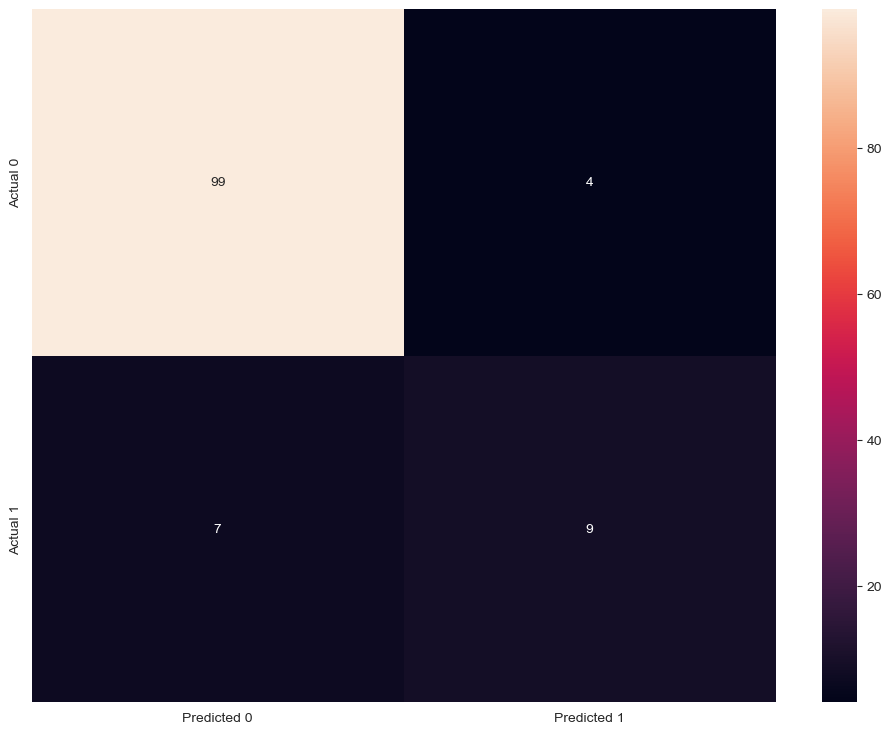

In [57]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1']);

Матрица выглядит неплохо! Метрики ниже ну тоже в целом не так плохи

In [61]:
print(f'accuracy = {accuracy_score(y_test_pred, y_test)}')
print(f'precision = {precision_score(y_test_pred, y_test)}')
print(f'recall = {recall_score(y_test_pred, y_test)}')
print(f'f1 = {f1_score(y_test_pred, y_test)}')

accuracy = 0.907563025210084
precision = 0.5625
recall = 0.6923076923076923
f1 = 0.6206896551724138


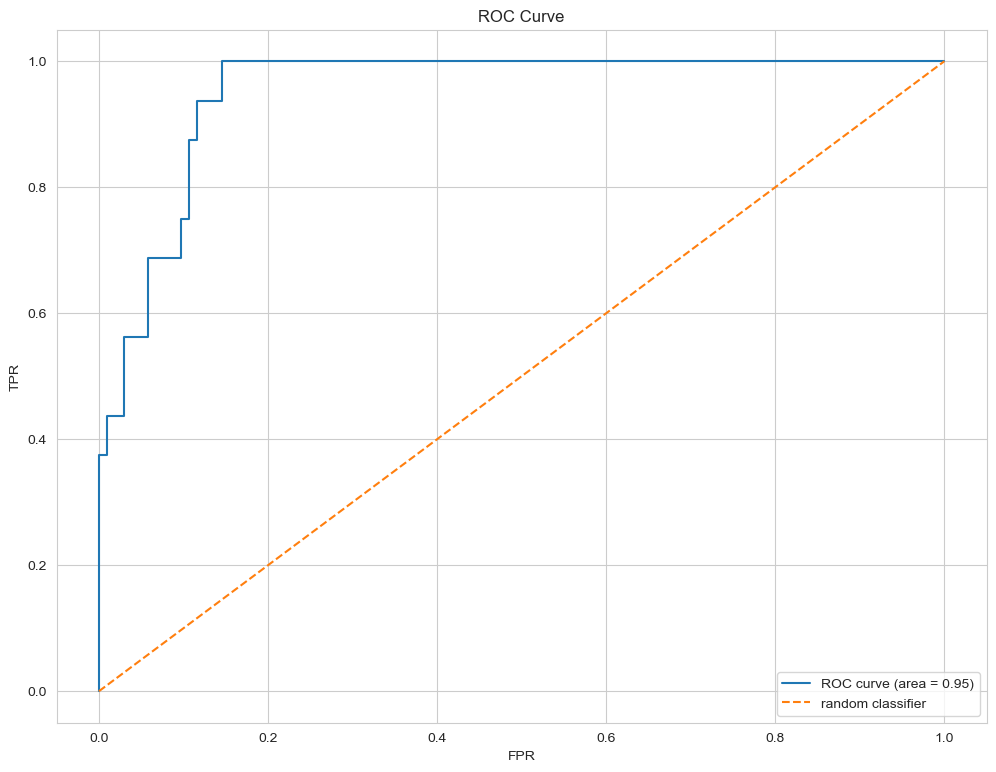

In [58]:
predicted_probabilities =  log_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, predicted_probabilities)
roc_auc = round(auc(fpr, tpr), 2)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], linestyle='--', label='random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

ROC кривая тоже хорошая, большая площадь говорит о том, что наша модель предсказывает сильно лучше рандомной

In [59]:
coeffs = log_pipeline.named_steps['log_reg'].coef_.tolist()[0]
num_features = log_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out().tolist()
cat_features = log_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist()
all_features = num_features+cat_features
coefficients_with_names = list(zip(all_features, coeffs))
print(sorted(coefficients_with_names, key=lambda x: x[1]))

[('Type 1_Normal', -0.5642709484353984), ('Type 1_Dragon', -0.5419503638788499), ('Type 1_Fighting', -0.3974534457440741), ('Type 1_Ghost', -0.37517848728602615), ('Type 1_Water', -0.32701462083803656), ('Type 1_Fairy', -0.2790088278194644), ('Type 1_Dark', -0.2333363846452431), ('Type 1_Fire', -0.21035376901927072), ('Type 1_Poison', -0.10073481068126308), ('Generation_3', -0.06807294866192154), ('Type 1_Grass', 7.377782630899185e-05), ('Type 1_Steel', 0.04344479550789003), ('Defense', 0.1970383890719979), ('Type 1_Rock', 0.2345463931961348), ('Generation_6', 0.28463672180931265), ('Generation_2', 0.29636364638294577), ('Type 1_Ice', 0.3037599656848361), ('Attack', 0.3766757575963881), ('Generation_4', 0.4886601829749821), ('Type 1_Flying', 0.7215537757540075), ('Type 1_Electric', 0.73292210978826), ('Type 1_Ground', 0.7617742646210353), ('HP', 0.8188930954179738), ('Sp. Atk', 1.0545115153473759), ('Type 1_Psychic', 1.0612968602323853), ('Generation_5', 1.0623354342516949), ('Sp. Def'

Самыми главными кажутся параметры Total, Speed, Sp. Atk, Sp. Def, Speed, каким-то образом может влиять Generation(?... ) - с категориальными как-то сложно понять

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

БИ-2!

Про знакомство вопрос интересный. Был в моей жизни период, когда я решила погрузиться в русский рок и слушала все подряд:) Кажется, что начала с "Полковнику никто не пишет", ну и понеслась. 

Держите best of the best:

1) [Нам не нужен герой](https://www.youtube.com/watch?v=853ugypwP3Y)
2) [Пора возвращаться домой](https://www.youtube.com/watch?v=kmxPFKIe4Zs)
3) [Лайки](https://www.youtube.com/watch?v=2B42OubTUd0&list=PLPKFnWFXcrUmsrdZh4axAc9JLJjXJPUq6&index=15)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Это понравилось больше предыдущего:)